### Imports

In [119]:
import numpy as np
from scipy.io import loadmat
from ternary.helpers import project_sequence

import tensorflow as tf

from scipy.spatial.distance import pdist, squareform

from sklearn.manifold import spectral_embedding
from sklearn.mixture import GaussianMixture
from matplotlib import path
import gpflow

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize
import ternary

In [120]:
mpl.rcParams["mathtext.default"] = 'regular'

### Load in the relevant data

In [154]:
# read the data from the control (fully autonomous) run
control_order = [163, 252, 226, 4, 150]

In [45]:
# import the experimental data, including the...
experimental_data = loadmat('FeGaPd_full_data_220104a.mat')

# ..."true" labels from the data set, ...
true_label = experimental_data['labels_col'][0][1].flatten()

# ...composition data in cartesian coordinates, ...
composition = experimental_data['C']
idx = [1, 2, 0]
cartesian = np.array(list(zip(*project_sequence(composition[:, idx]))))

# ...and x ray diffraction data
xrd = experimental_data['X'][:, 631:1181]

### Set the random seeds

In [46]:
# seed the numpy and tensorflow random number generation for reproducability
seed = 1
rng = np.random.RandomState(seed)
tf.random.set_seed(seed)

### Gaussian Process Classification Methods

In [47]:
def similarity_matrix(X, metric, sigma=1):
    '''
    Calculate and return the similarity matrix used in spectral clustering.

    Parameters
    ----------
    X: m x n matrix - m rows of n dimensional data
    metric: distance metric passed to scipy.spatial.distance.pdist()
    sigma: scaling factor for Gaussian radial basis function (default=1)
    '''

    distance = squareform(pdist(X, metric))
    W = np.exp(-(distance**2) / (2*sigma**2))
    return W

In [48]:
def phase_mapping(X, num_clusters, random_state):
    '''
    Cluster data using spectral clustering and a Gaussian mixture model

    Parameters
    ----------
    X: m x n matrix - m rows of n dimensional data
    num_clusters: number of groups to cluster data into

    Returns
    -------
    cl: clustering labels for each sample
    cluster_prob: the probability for each sample to belong to each cluster
    '''

    K = similarity_matrix(X, 'cosine')

    if X.shape[0] <= num_clusters:
        # fewer data points than clusters, each point gets its own cluster
        cluster_prob = np.eye(X.shape[0])
    else:
        x_se = spectral_embedding(adjacency=K,
                                  n_components=num_clusters,
                                  random_state=random_state)
        model = GaussianMixture(n_components=num_clusters,
                                covariance_type='diag',
                                n_init=10,
                                random_state=random_state).fit(x_se)

        cluster_prob = model.predict_proba(x_se)

    cl = np.argmax(cluster_prob, axis=1).flatten()
    return cl, cluster_prob


In [49]:
def gpc_phasemapping(xy_curr, labels_curr, xy_full, num_clusters, 
                     weight_prior=None, points=None):
    '''
    Take clustering labels for the samples and then extrapolate them throughout
    composition space, segmenting the XY space into 'phase regions'.

    Parameters
    ----------
    xy_curr: cartesian coordinates of measured data points
    labels_curr: cluster labels for those data
    xy_full: cartesian coordinates of measured and new, query data points
    num_clusters: the number of clusters we're assuming exist
    weight_prior: variance coefficient factor of (optional) prior kernel

    Returns
    -------
    y_mean: data point label predictions
    y_variance: data point label variances
    f_mean: data point latent GP predictions
    f_variance: data point latent GP variances
    points: a list of tuples of the user input cartesian coordinates
    '''

    data = (xy_curr, labels_curr)

    composition_kernel = gpflow.kernels.Matern32(active_dims=[0, 1],
                                                 lengthscales=[0.2, 0.2],
                                                 variance=1)

    gpflow.utilities.set_trainable(composition_kernel.lengthscales, False)
    gpflow.utilities.set_trainable(composition_kernel.variance, False)

    if weight_prior is None:
        kernel = composition_kernel
    else:
        if len(points) == 2:
            # user input was a boundary
            prior_kernel = gpflow.kernels.SquaredExponential(
                active_dims=[2],
                lengthscales=0.001,
                variance=weight_prior)

            # fix all the kernel hyperparameters
            gpflow.utilities.set_trainable(prior_kernel.lengthscales, False)
            gpflow.utilities.set_trainable(prior_kernel.variance, False)
        else:
            # user input was a region
            prior_kernel = gpflow.kernels.Linear(active_dims=[2],
                                                 variance=weight_prior)

            gpflow.utilities.set_trainable(prior_kernel.variance, False)

        kernel = composition_kernel + prior_kernel

    invlink = gpflow.likelihoods.RobustMax(num_clusters)

    gpflow.utilities.set_trainable(invlink.epsilon, True)

    likelihood = gpflow.likelihoods.MultiClass(num_clusters, invlink=invlink)

    model = gpflow.models.VGP(data=data,
                              kernel=kernel,
                              likelihood=likelihood,
                              num_latent_gps=num_clusters)

    # hyperparameter optimization
    opt = gpflow.optimizers.Scipy()
    opt_result = opt.minimize(model.training_loss,
                              model.trainable_variables,
                              options={'maxiter': 1000, 'iprint': 100})

    # Poisson process for the full XY coordinates
    y = model.predict_y(xy_full)
    y_mean = y[0].numpy()
    y_variance = y[1].numpy()

    # (non-squeezed) probabilistic function for class labels
    f = model.predict_f(xy_full)
    f_mean = f[0].numpy()
    f_variance = f[1].numpy()

    return y_mean, y_variance, f_mean, f_variance


In [145]:
def get_hitl_labels(points):
    '''
    Return the 5th iteration clustering results using the provided user input
    
    Parameters
    ----------
    points: a list of tuples of the user input cartesian coordinates
    '''

    if len(points) < 2:
        raise ValueError('User didn\'t add enough points.')
    elif len(points) == 2:
        # user drew a line
        x1, y1 = points[0]
        x2, y2 = points[1]

        # calculate the distance between each point the line
        d = [(x-x1)*(y2-y1)-(y-y1)*(x2-x1) for (x, y) in cartesian]

        user_labels = [1 if distance > 0 else 0 for distance in d]
    else:
        # user draw a polygon
        polygon = path.Path(points)

        user_labels = polygon.contains_points(cartesian)
    
    labels, _ = phase_mapping(xrd[control_order[:5], :], 5, rng)

    # use the user labels as input
    data_with_prior = np.column_stack((cartesian, user_labels))

    y_mean, _, _, _ = gpc_phasemapping(data_with_prior[control_order[:5], :],
                                       labels,
                                       data_with_prior,
                                       5,
                                       weight_prior=1,
                                       points=points)

    return(y_mean)


### Figure Drawing Methods

In [89]:
def prior_with_input(tax, points):
    '''
    Draw the provided user points on top of the 4th iteration clustering
    
    Parameters
    ----------
    tax: the ternary axes on which to create the plot
    points: a list of tuples of the user input cartesian coordinates
    '''

    y_mean, _, _, _ = gpc_phasemapping(cartesian[control_order[:4], :],
                                       [0, 1, 2, 3],
                                       cartesian,
                                       5)

    control_labels = np.argmax(y_mean, 1)

    # get all the point colors in advance because the "edgecolors" parameter 
    # doesn't accept a list of values like the parameters "c" does
    point_colors = plt.cm.get_cmap()(Normalize()(control_labels))

    # plot all points as empty circles
    tax.get_axes().scatter(cartesian[:, 0],
                           cartesian[:, 1], 
                           edgecolors=point_colors,
                           facecolors='none',
                           marker='o')

    # fill measured points
    tax.get_axes().scatter(cartesian[control_order[:4], 0],
                           cartesian[control_order[:4], 1], 
                           c=point_colors[control_order[:4]],
                           marker='o')

    # create separate x and y coordinate lists for every point in points
    x, y = zip(*points)

    tax.get_axes().plot(x, y, 'k*-')

    decorate_plot(tax)

In [149]:
def input_result(tax, points):
    '''
    Draw the 5th iteration clustering results after using the provided input
    
    Parameters
    ----------
    tax: the ternary axes on which to create the plot
    points: a list of tuples of the user input cartesian coordinates
    '''

    y_mean = get_hitl_labels(points)

    control_labels = np.argmax(y_mean, 1)

    # get all the point colors in advance because the "edgecolors" parameter 
    # doesn't accept a list of values like the parameters "c" does
    point_colors = plt.cm.get_cmap()(Normalize()(control_labels))

    # plot all points as empty circles
    tax.get_axes().scatter(cartesian[:, 0],
                           cartesian[:, 1], 
                           edgecolors=point_colors,
                           facecolors='none',
                           marker='o')

    # fill measured points
    tax.get_axes().scatter(cartesian[control_order, 0],
                           cartesian[control_order, 1], 
                           c=point_colors[control_order],
                           marker='o')

    decorate_plot(tax)

In [156]:
def control_result(tax):
    '''
    Draw the 5th iteration clustering results without user input
    
    Parameters
    ----------
    tax: the ternary axes on which to create the plot
    '''

    y_mean, _, _, _ = gpc_phasemapping(cartesian[control_order, :],
                                       [0, 1, 2, 3, 4],
                                       cartesian,
                                       5)

    control_labels = np.argmax(y_mean, 1)

    # get all the point colors in advance because the "edgecolors" parameter 
    # doesn't accept a list of values like the parameters "c" does
    point_colors = plt.cm.get_cmap()(Normalize()(control_labels))

    # plot all points as empty circles
    tax.get_axes().scatter(cartesian[:, 0],
                           cartesian[:, 1], 
                           edgecolors=point_colors,
                           facecolors='none',
                           marker='o')

    # fill measured points
    tax.get_axes().scatter(cartesian[control_order, 0],
                           cartesian[control_order, 1], 
                           c=point_colors[control_order],
                           marker='o')

    decorate_plot(tax)

In [141]:
def decorate_plot(tax):
    # plot decoration
    tax.set_background_color('white')
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('square')

    tax.get_axes().text(0.06, 0.02,
                        "$Fe$",
                        fontsize=15,
                        verticalalignment='center',
                        horizontalalignment='center')

    tax.get_axes().text(0.57, 0.02,
                        "$Fe_{40}Ga_{60}$",
                        fontsize=15,
                        verticalalignment='center',
                        horizontalalignment='center')

    tax.get_axes().text(0.3, 0.5,
                        "$Fe_{40}Pd_{60}$",
                        fontsize=15,
                        verticalalignment='center',
                        horizontalalignment='center')


### Create and save the figures

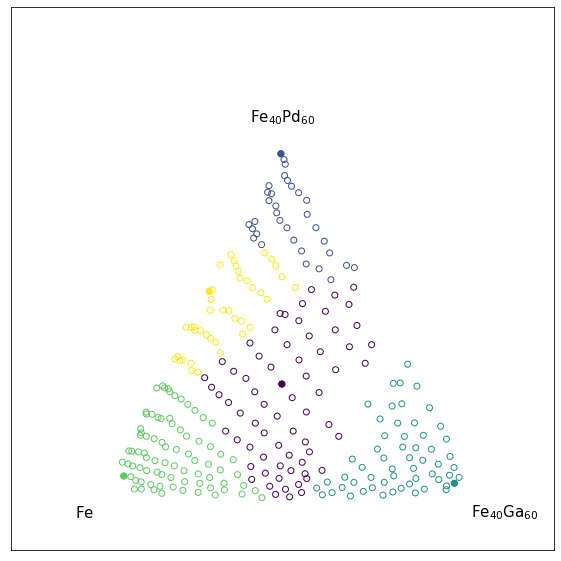

In [157]:
fig, ax = plt.subplots(figsize=(10, 10))
tax = ternary.TernaryAxesSubplot(ax, scale=0.6)

control_result(tax)

plt.show()